# K-means

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
import numpy as np

In [2]:
mat = sio.loadmat('ex7data2.mat')

In [3]:
data = pd.DataFrame(mat.get('X'), columns=['X1', 'X2'])

In [4]:
data.sample(3)

,X1,X2
41,2.591486,4.925934
110,2.879611,0.754137
253,6.927220,3.199600


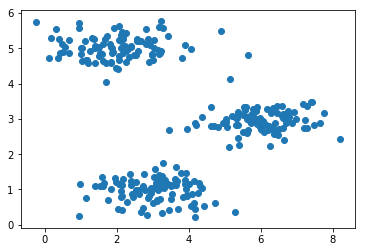

In [5]:
plt.scatter(data.X1, data.X2)

### Helper functions

In [6]:
def combine_data_C(data, C):
    """combine C (centoid number which a sample belongs to) with data"""
    data_with_c = data.copy()
    data_with_c['C'] = C
    return data_with_c

def cost(data, centroids, C):
    """calculate cost of current cluster state"""
    m = data.shape[0]
    expand_C_with_centroids = centroids[C]
    distances = np.apply_along_axis(np.linalg.norm, # this function returns l2 norm
                                    axis=1, 
                                    arr=data.values - expand_C_with_centroids
                                   )
    return distances.sum() / m

### Step 1: Randomly choose k centroids from data set

In [7]:
def random_init(data, k):
    return data.sample(k).values

In [8]:
init_centroids = random_init(data, 3)
init_centroids

array([[7.21684033, 2.72896575],
       [7.24694794, 2.96877424],
       [1.30882588, 5.30158701]])

### Step 2: Assign cluster 

In [9]:
def _find_your_cluster(x, centroids):
    """find which centoid the sample belongs to. choose the one with lowest l2 norm"""
    distances = np.apply_along_axis(func1d=np.linalg.norm, # this function returns l2 norm
                                    axis=1, 
                                    arr=centroids - x # numpy broadcast
                                   )
    return np.argmin(distances)

def assign_cluster(data, centroids):
    """
    assign cluster for each node in data.
    """
    return np.apply_along_axis(lambda x: _find_your_cluster(x, centroids), 
                               axis=1, 
                               arr=data.values)

In [10]:
C = assign_cluster(data, init_centroids)
data_with_c = combine_data_C(data, C)
print(cost(data, init_centroids, C))
data_with_c.sample(3)

2.2012258388433406


,X1,X2,C
79,0.363917,4.733328,2
211,6.641072,3.059987,1
81,2.286648,5.007670,2


### Step 3: Calculate new centroids 

In [11]:
def new_centroids(data, C):
    """calculate new centroids"""
    data_with_c = combine_data_C(data, C)
    return data_with_c.groupby('C', as_index=False).mean().sort_values(by='C').drop('C', axis=1).values


In [12]:
centroids = new_centroids(data, C)
print(cost(data, centroids, C))
centroids

1.5634399363816218


array([[4.64835848, 1.83305548],
       [6.30033012, 3.29828737],
       [2.02602789, 3.87467426]])

# Iterate througn step 2 to step3

In [13]:
def _k_means_iter(data, k, epoch=100, tol=0.0001):
    """one shot k-means with early break
    Parameters:
        data: DataFrame -> raw data
        k: int -> number of clusters
        epoch: int -> max number of iterations
        tol: float -> improvement over last iteration
    """
    centroids = random_init(data, k)
    cost_progress = []
    for i in range(epoch):
        # cluster assign
        C = assign_cluster(data, centroids)
        
        # calculate the cost 
        cost_progress.append(cost(data, centroids, C))
        print('running epoch {}, {}'.format(i, cost_progress[-1]))
        
        # calculate new centroids
        centroids = new_centroids(data, C)
        
        if len(cost_progress) > 1: # at least two iteration
            if (np.abs(cost_progress[-1] - cost_progress[-2])) / cost_progress[-1] < tol: # nothing to improve
                break
        
    return C, centroids, cost_progress[-1]

running epoch 0, 1.6501045770539493
running epoch 1, 1.5079017139625026
running epoch 2, 1.2927569408058568
running epoch 3, 0.9496379585736439
running epoch 4, 0.7973272652708293
running epoch 5, 0.794176363371587
running epoch 6, 0.794176363371587


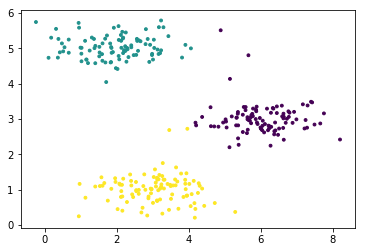

In [14]:
C, centroids, _ = _k_means_iter(data, 3, 20)
plt.scatter(data.X1, data.X2, s=8, c=C)

## Multiple random initialization

K-means might stuck in local optimal, so we need several random initialization to avoid that

In [15]:
def k_means(data, k, epoch=100, n_init=10):
    """do multiple random init and pick the best one to return"""
    tries = np.array([_k_means_iter(data, k, epoch) for _ in range(n_init)])
    least_cost_idx = np.argmin(tries[:, -1])
    return tries[least_cost_idx]

In [16]:
k_means(data, 3, 20, 10)

running epoch 0, 1.8060001974686182
running epoch 1, 1.4265871043741287
running epoch 2, 0.8656644608391237
running epoch 3, 0.794176363371587
running epoch 4, 0.794176363371587
running epoch 0, 1.6884999901116915
running epoch 1, 1.4800013735394328
running epoch 2, 0.933092530426145
running epoch 3, 0.7963778144203622
running epoch 4, 0.794176363371587
running epoch 5, 0.794176363371587
running epoch 0, 1.8071193891418424
running epoch 1, 0.8482134692549453
running epoch 2, 0.7933529008645198
running epoch 3, 0.794176363371587
running epoch 4, 0.794176363371587
running epoch 0, 1.0697828568963943
running epoch 1, 0.794657388050982
running epoch 2, 0.794176363371587
running epoch 3, 0.794176363371587
running epoch 0, 0.9890696603384606
running epoch 1, 0.7933529008645198
running epoch 2, 0.794176363371587
running epoch 3, 0.794176363371587
running epoch 0, 1.760606461252362
running epoch 1, 1.0294014038206944
running epoch 2, 0.8113410677713504
running epoch 3, 0.7940418155436358
runni

array([array([1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2